# pyEDITH Tutorial: Imaging Mode

This tutorial will guide you through using pyEDITH in imaging mode.

## Before we start

Make sure you download the latest YAML files  at https://github.com/HWO-GOMAP-Working-Groups/Sci-Eng-Interface/tree/main
and a folder that contains your Coronagraph Input Package YIP files.

## Setup
First, let's import the necessary modules and set up our environment:


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from pyEDITH import parse_input, calculate_texp, calculate_snr, AstrophysicalScene, Observation, ObservatoryBuilder
from pyEDITH.units import *

# Set the necessary environment variables --> REPLACE WITH YOUR PATHS. 
# You can also open your .bashrc (or .zshrc) and type:
# export SCI_ENG_DIR="/path/to/Sci-Eng-Interface/hwo_sci_eng"
# export YIP_CORO_DIR="/path/to/yips"


os.environ['SCI_ENG_DIR']="/Users/ealei/Coding/Sci-Eng-Interface/hwo_sci_eng"
os.environ['YIP_CORO_DIR']="/Users/ealei/Coding/yips"


### 1. Setting up the Observation Parameters

Let's start by defining the parameters for an Earth-like planet around HIP 79672 (used in the ETC validation).

**Note:** Parameters that vary with lambda (lambd, resolution, snr, mag, delta_mag...) can be both floats and lists. If len(lambd)>1 and any of the other values is a float, it becomes a list of length len(lambd) internally.

In [ ]:

imaging_params = {
    'wavelength': 0.5,  # Wavelength in microns
    'snr': 7,  # Desired signal-to-noise ratio
    'bandwidth': 0.2,  # Bandwidth of observation
    'photap_rad': 0.85,  # Photometric aperture radius
    'CRb_multiplier': 2.0,  # Contrast ratio multiplier
    'Lstar': 1.8,  # Stellar luminosity in Solar luminosity units
    'magV': 5.44,  # Stellar magnitude in V band
    'mag': 5.687,  # Stellar magnitude in observation band
    'distance': 18.2,  # Distance to star in parsecs
    'angular_diameter': 0.0006,  # Angular diameter of star in arcseconds
    'nzodis': 3.0,  # Number of zodiacal light disks
    'ra': 101.5589542028,  # Right ascension of star
    'dec': 79.56481016336,  # Declination of star
    'separation': 0.07420559867718164,  # Separation between star and planet in arcseconds
    'delta_mag_min': 25,  # Minimum delta magnitude
    'delta_mag': 25.5,  # Delta magnitude between star and planet
    'observatory_preset': 'EAC1',  # Preset observatory configuration
    'observing_mode': 'IMAGER',  # Observing mode
}


### 2. Calculating Exposure Time
Now, let's calculate the exposure time for our imaging observation:

In [3]:
# make the parameters be the shape that the code desires 
parsed_parameters= parse_input.parse_parameters(imaging_params)
#calculate Exposure time
texp, validation_output = calculate_texp(parsed_parameters, verbose=False)
print(f"Calculated exposure time: {texp.to(u.hr)}")

KeyError: 'photap_rad'

### 3. Calculate SNR

Given an exposure time (e.g. 10 hrs), we can calculate the SNR for the desired bandpass.

In [4]:
# make the parameters be the shape that the code desires 
parsed_parameters= parse_input.parse_parameters(imaging_params)
#calculate SNR

texp = 10*u.hr
snr, validation_output = calculate_snr(parsed_parameters, texp, verbose=False)
print(f"Calculated snr: {snr}")

Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-14 14:07:21,407] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-14 14:07:21,408] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-14 14:07:21,409] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-14 14:07:21,443] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-14 14:07:21,467] Created usort_offaxis_ovc


Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...
Calculated snr: [5.46431512]


`validation_output` contains some interesting quantities that you can use to double check or validate, or to plot additional quantities.

In [5]:
validation_output

{0: {'F0': <Quantity 12638.83670769 ph / (nm s cm2)>,
  'magstar': <Quantity [5.687] mag>,
  'Lstar': <Quantity 1.8 solLum>,
  'dist': <Quantity 18.2 pc>,
  'D': <Quantity 7.225765 m>,
  'A_cm': <Quantity 410069.58591604 cm2>,
  'wavelength': <Quantity 500. nm>,
  'deltalambda_nm': <Quantity 100. nm>,
  'snr': <Quantity 7.>,
  'nzodis': <Quantity 3. zodi>,
  'toverhead_fixed': <Quantity 8250. s>,
  'toverhead_multi': <Quantity 1.1>,
  'det_DC': <Quantity 3.e-05 electron / (pix s)>,
  'det_RN': <Quantity 0.1 electron / (pix read)>,
  'det_CIC': <Quantity 0. electron / (frame pix)>,
  'det_tread': <Quantity 1000. s / read>,
  'det_pixscale_mas': <Quantity 7.13643491 mas>,
  'dQE': <Quantity 0.75>,
  'QE': <Quantity 0.88749741 electron / ph>,
  'Toptical': <Quantity 0.36198356>,
  'Fstar': <Quantity 67.12852472 ph / (nm s cm2)>,
  'Fp': <Quantity 4.23552357e-09 ph / (nm s cm2)>,
  'Fzodi': <Quantity 4.71862514e-06 ph / (nm s arcsec2 cm2)>,
  'Fexozodi': <Quantity 4.95627062e-05 arcsec^-2 

### 4. Simultaneous Observations (primary Exposure Time informs secondary SNR)

This is useful to simulate simultaneous observations. For example, we assume the primary (detection) bandpass to be 0.5 micron with 20% bandwidth. What is the SNR of a secondary bandpass at 1 micron with 20% bandpass?

In [6]:
# Let's note down the values that change compared to imaging_params
secondary_imaging_params = {
    'wavelength': 1,  # Wavelength in microns
    'mag': 4.742178,  # Stellar magnitude in observation band
    }

#fill the missing values
for key in imaging_params:
        if key not in secondary_imaging_params:
            secondary_imaging_params[key] = imaging_params[key]

print("Calculating texp from primary lambda")
parsed_parameters= parse_input.parse_parameters(imaging_params)
texp, _ = calculate_texp(parsed_parameters, verbose=False)
print("Reference exposure time: ", texp.to(u.hr))
if np.isfinite(texp).all():
    print("Calculating snr on secondary lambda")
    parsed_secondary_parameters= parse_input.parse_parameters(secondary_imaging_params)

    snr, _ = calculate_snr(parsed_secondary_parameters, texp, verbose=True)
    print("SNR at the secondary lambda: ", snr)
else:
    raise ValueError("Returned exposure time is infinity.")

Calculating texp from primary lambda
Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-14 14:07:26,122] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-14 14:07:26,124] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-14 14:07:26,124] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-14 14:07:26,155] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-14 14:07:26,171] Created usort_offaxis_ovc


Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...
Reference exposure time:  [14.94150852] h
Calculating snr on secondary lambda
Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-14 14:07:31,137] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-14 14:07:31,138] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-14 14:07:31,139] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-14 14:07:31,178] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-14 14:07:31,196] Created usort_offaxis_ovc


Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...
SNR at the secondary lambda:  [2.78252477]


### 5. Exploring The Parameter Space


#### 5.1. Planet-to-star contrast
Let's explore how the exposure time changes with planet-to-star contrast:



Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-14 14:07:36,359] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-14 14:07:36,361] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-14 14:07:36,362] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-14 14:07:36,394] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-14 14:07:36,417] Created usort_offaxis_ovc


Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...
Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-14 14:07:41,255] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-14 14:07:41,256] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-14 14:07:41,257] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-14 14:07:41,289] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-14 14:07:41,305] Created usort_offaxis_ovc


Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...
Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-14 14:07:46,109] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-14 14:07:46,110] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-14 14:07:46,111] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-14 14:07:46,257] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-14 14:07:46,284] Created usort_offaxis_ovc


Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...
Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-14 14:07:51,256] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-14 14:07:51,258] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-14 14:07:51,258] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-14 14:07:51,295] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-14 14:07:51,317] Created usort_offaxis_ovc


Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...
Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-14 14:07:56,012] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-14 14:07:56,013] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-14 14:07:56,014] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-14 14:07:56,051] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-14 14:07:56,067] Created usort_offaxis_ovc


Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...
Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-14 14:08:00,682] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-14 14:08:00,683] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-14 14:08:00,683] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-14 14:08:00,716] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-14 14:08:00,734] Created usort_offaxis_ovc


Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...
Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-14 14:08:05,379] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-14 14:08:05,380] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-14 14:08:05,381] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-14 14:08:05,420] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-14 14:08:05,446] Created usort_offaxis_ovc


Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...
Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-14 14:08:10,377] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-14 14:08:10,378] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-14 14:08:10,379] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-14 14:08:10,411] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-14 14:08:10,427] Created usort_offaxis_ovc


Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...
Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-14 14:08:15,067] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-14 14:08:15,068] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-14 14:08:15,069] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-14 14:08:15,102] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-14 14:08:15,118] Created usort_offaxis_ovc


Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...
Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-14 14:08:19,861] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-14 14:08:19,863] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-14 14:08:19,863] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-14 14:08:19,899] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-14 14:08:19,915] Created usort_offaxis_ovc


Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...


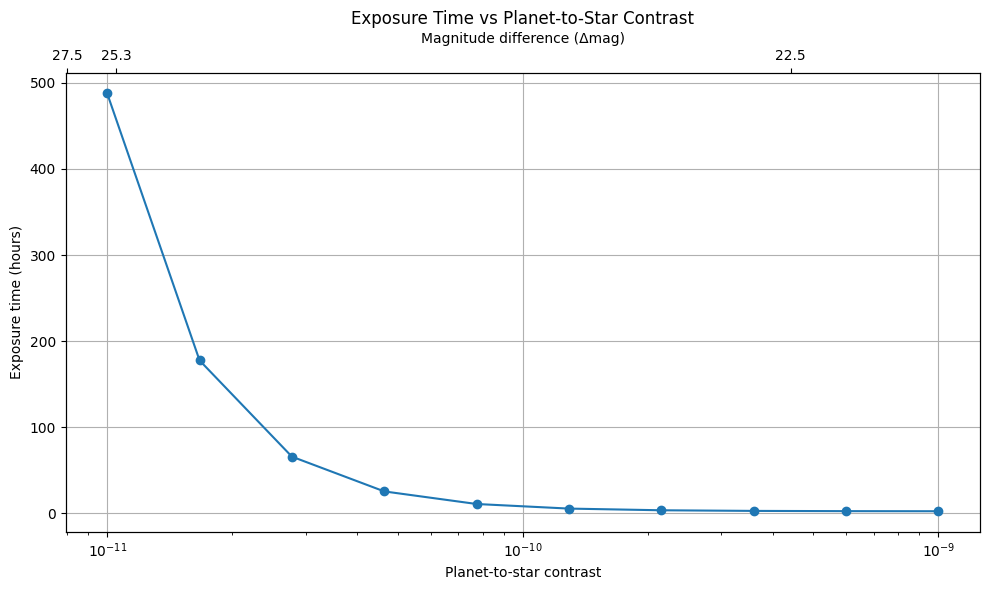

In [7]:
contrasts = np.logspace(-11, -9, 10)
magnitudes = -2.5 * np.log10(contrasts)
exposure_times = []


for magnitude in magnitudes:
    params = imaging_params.copy()
    params['delta_mag'] = magnitude
    # make the parameters be the shape that the code desires 
    parsed_parameters= parse_input.parse_parameters(params)
    texp, validation_output = calculate_texp(parsed_parameters, verbose=False)


    exposure_times.append(texp.to(u.hr).value)

fig, ax1 = plt.subplots(figsize=(10, 6))
# Primary x-axis (contrast)
ax1.semilogx(contrasts, exposure_times,marker='o')
ax1.set_xlabel('Planet-to-star contrast')
ax1.set_ylabel('Exposure time (hours)')
ax1.grid(True)

# Secondary x-axis (magnitude)
ax2 = ax1.twiny()
ax2.set_xscale('linear')
ax2.set_xlim(ax1.get_xlim())

# Reduce ticks on secondary axis
num_ticks = 3 
tick_indices = np.linspace(0, len(contrasts) - 1, num_ticks, dtype=int)
reduced_contrasts = [contrasts[i] for i in tick_indices]
reduced_magnitudes = [magnitudes[i] for i in tick_indices]
ax2.set_xticks(reduced_contrasts)
ax2.set_xticklabels([f'{m:.1f}' for m in reduced_magnitudes])
ax2.set_xlabel('Magnitude difference (Δmag)')

plt.title('Exposure Time vs Planet-to-Star Contrast')
plt.tight_layout()
plt.show()



#### 5.2 Separation

Now let's change the separation of the planet and see how the exposure time changes.

Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-14 14:08:24,725] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-14 14:08:24,726] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-14 14:08:24,727] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-14 14:08:24,766] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-14 14:08:24,784] Created usort_offaxis_ovc


Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...
Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-14 14:08:29,390] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-14 14:08:29,391] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-14 14:08:29,392] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-14 14:08:29,425] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-14 14:08:29,441] Created usort_offaxis_ovc


Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...
Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-14 14:08:34,124] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-14 14:08:34,126] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-14 14:08:34,126] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-14 14:08:34,168] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-14 14:08:34,185] Created usort_offaxis_ovc


Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...
Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-14 14:08:38,877] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-14 14:08:38,878] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-14 14:08:38,878] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-14 14:08:38,917] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-14 14:08:38,933] Created usort_offaxis_ovc


Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...
Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-14 14:08:43,808] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-14 14:08:43,809] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-14 14:08:43,810] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-14 14:08:43,844] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-14 14:08:43,860] Created usort_offaxis_ovc


Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...
Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-14 14:08:48,631] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-14 14:08:48,632] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-14 14:08:48,633] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-14 14:08:48,666] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-14 14:08:48,686] Created usort_offaxis_ovc


Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...
Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-14 14:08:53,505] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-14 14:08:53,507] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-14 14:08:53,507] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-14 14:08:53,540] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-14 14:08:53,555] Created usort_offaxis_ovc


Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...
Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-14 14:08:58,181] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-14 14:08:58,182] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-14 14:08:58,183] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-14 14:08:58,223] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-14 14:08:58,243] Created usort_offaxis_ovc


Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...
Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-14 14:09:02,881] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-14 14:09:02,882] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-14 14:09:02,882] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-14 14:09:02,919] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-14 14:09:02,935] Created usort_offaxis_ovc


Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...
Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-14 14:09:07,572] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-14 14:09:07,573] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-14 14:09:07,573] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-14 14:09:07,610] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-14 14:09:07,625] Created usort_offaxis_ovc


Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...


/var/folders/10/v9qwyn2d7mx1blfr1v345wz80000gp/T/ipykernel_62876/1873697519.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


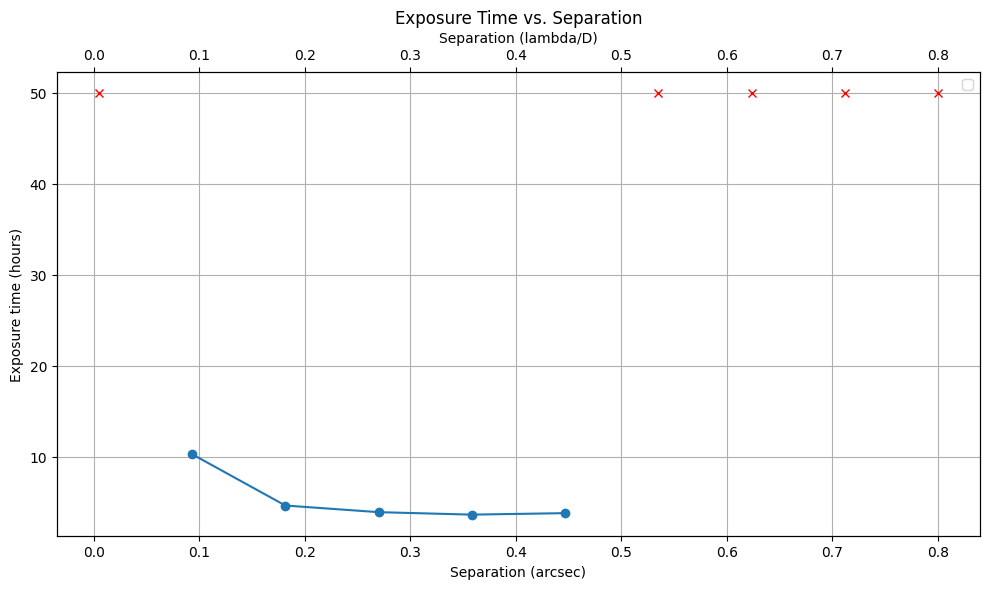

In [8]:
separations = np.linspace(0.005, 0.8, 10)  # arcsec 

exposure_times = []

for sep in separations:
    params = imaging_params.copy()
    params['separation'] = sep
    parsed_parameters= parse_input.parse_parameters(params)
    texp, _ = calculate_texp(parsed_parameters, verbose=False)
    exposure_times.append(texp.to(u.hr)[0].value)


fig, ax1 = plt.subplots(figsize=(10, 6))
# Primary x-axis (separation arcsec)
ax1.plot(separations, exposure_times, marker='o', label='Valid exposures')
ax1.plot(separations[np.isinf(exposure_times)],
         np.ones_like(separations)[np.isinf(exposure_times)]*50,
         marker='x', linestyle='', color='red', label='Infinite exposures')


ax1.set_xlabel('Separation (arcsec)')
ax1.set_ylabel('Exposure time (hours)')
ax1.grid(True)

separations_lod = arcsec_to_lambda_d(separations*ARCSEC,
0.5*u.micron.to(LENGTH),
8.78*u.m.to(LENGTH),
)
# # Secondary x-axis (lambda/D)
num_ticks = 5 
tick_indices = np.linspace(0, len(separations) - 1, num_ticks, dtype=int)
reduced_separations = [separations[i] for i in tick_indices]
reduced_separations_lod = [separations_lod[i] for i in tick_indices]
ax2.set_xticks(reduced_separations)
ax2.set_xticklabels([f'{m:.1f}' for m in reduced_separations_lod])
ax2 = ax1.twiny()

ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel('Separation (lambda/D)')

plt.title('Exposure Time vs. Separation')
plt.legend()
plt.tight_layout()
plt.show()




#### 5.3 Telescope Diameter

And finally, we can change the telescope diameter and see the impact on the exposure time.

Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-14 14:09:12,334] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-14 14:09:12,335] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-14 14:09:12,336] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-14 14:09:12,368] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-14 14:09:12,382] Created usort_offaxis_ovc


Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...
Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-14 14:09:17,111] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-14 14:09:17,112] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-14 14:09:17,113] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-14 14:09:17,175] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-14 14:09:17,193] Created usort_offaxis_ovc


Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...
Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-14 14:09:21,967] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-14 14:09:21,968] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-14 14:09:21,968] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-14 14:09:22,002] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-14 14:09:22,022] Created usort_offaxis_ovc


Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...
Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-14 14:09:26,664] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-14 14:09:26,665] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-14 14:09:26,665] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-14 14:09:26,698] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-14 14:09:26,717] Created usort_offaxis_ovc


Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...
Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-14 14:09:31,353] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-14 14:09:31,355] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-14 14:09:31,355] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-14 14:09:31,389] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-14 14:09:31,403] Created usort_offaxis_ovc


Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...
Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-14 14:09:36,211] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-14 14:09:36,212] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-14 14:09:36,212] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-14 14:09:36,251] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-14 14:09:36,266] Created usort_offaxis_ovc


Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...


/var/folders/10/v9qwyn2d7mx1blfr1v345wz80000gp/T/ipykernel_62876/1432815686.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


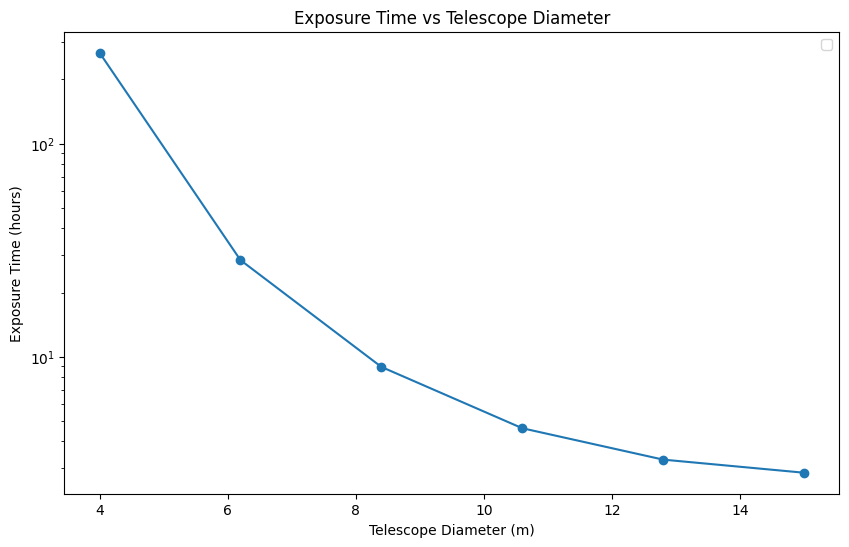

In [9]:
diameters = np.linspace(4, 15, 6)  

exposure_times = []

for diam in diameters:
    params = imaging_params.copy()
    params['diameter'] = diam # will overwrite the standard EAC1 telescope diameter
    parsed_parameters= parse_input.parse_parameters(params)
    texp, _ = calculate_texp(parsed_parameters, verbose=False)
    exposure_times.append(texp.to(u.hr)[0].value)


plt.figure(figsize=(10, 6))
plt.plot(diameters, exposure_times, marker='o')

plt.xlabel('Telescope Diameter (m)')
plt.ylabel('Exposure Time (hours)')
plt.title('Exposure Time vs Telescope Diameter')
plt.legend()
plt.yscale('log')
plt.show()


## 6. Advanced Tutorials

From the previous examples you noticed that we called `calculate_texp` in a loop multiple times. This makes the code start over and over, which slows down the process for large loops. If you want to speed up the calculation, you can work within `calculate_texp` and loop only what you need. Here are the contents of `calculate_texp`.

In [10]:
from pyEDITH import calculate_exposure_time_or_snr, parse_input
params = imaging_params.copy()

# Parse the desired parameters
parsed_parameters= parse_input.parse_parameters(params)

# Define Observation and load relevant parameters
observation = Observation()
observation.load_configuration(parsed_parameters)
observation.set_output_arrays()
observation.validate_configuration()

# Define Astrophysical Scene and load relevant parameters,
# then calculate zodi/exozodi
scene = AstrophysicalScene()
scene.load_configuration(parsed_parameters)
scene.calculate_zodi_exozodi(observation)
scene.validate_configuration()

# Create and configure Observatory using ObservatoryBuilder
observatory_config = parse_input.get_observatory_config(parsed_parameters)
observatory = ObservatoryBuilder.create_observatory(observatory_config)
ObservatoryBuilder.configure_observatory(
    observatory, parsed_parameters, observation, scene
)
observatory.validate_configuration()

# EXPOSURE TIME CALCULATION
calculate_exposure_time_or_snr(
    observation,
    scene,
    observatory,
    verbose=False,
    mode="exposure_time",
)

Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-14 14:09:41,318] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-14 14:09:41,322] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-14 14:09:41,322] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-14 14:09:41,359] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-14 14:09:41,376] Created usort_offaxis_ovc


Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...


If we want to loop, we would just do (separation example):

Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-14 14:09:46,528] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-14 14:09:46,530] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-14 14:09:46,530] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-14 14:09:46,573] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-14 14:09:46,590] Created usort_offaxis_ovc


Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...


/var/folders/10/v9qwyn2d7mx1blfr1v345wz80000gp/T/ipykernel_62876/1424174634.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


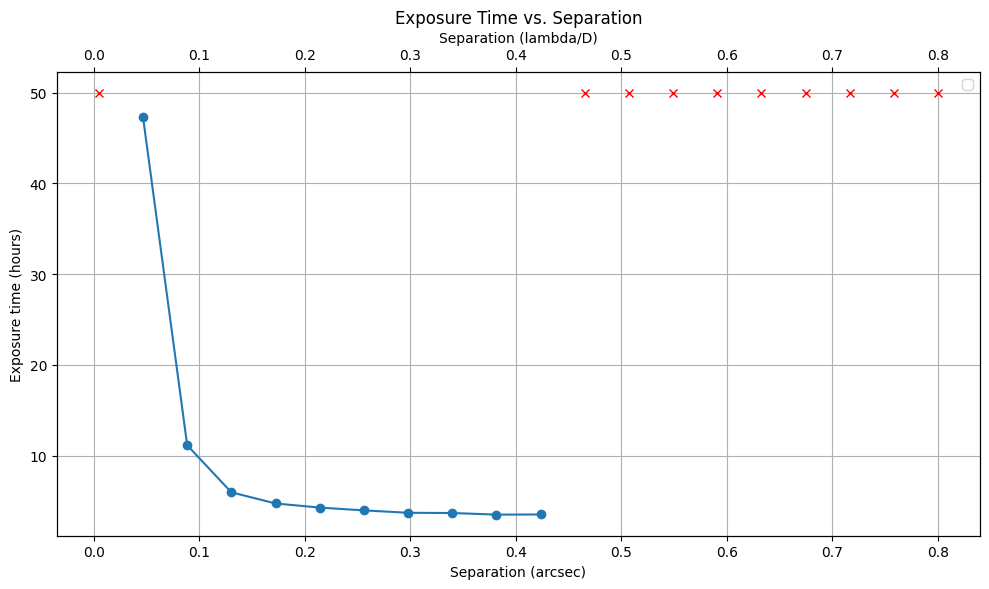

In [11]:
separations = np.linspace(0.005, 0.8, 20)  # arcsec 

exposure_times=[]
params = imaging_params.copy()

from pyEDITH import calculate_exposure_time_or_snr, parse_input

# Parse the desired parameters
parsed_parameters= parse_input.parse_parameters(params)

# Define Observation and load relevant parameters
observation = Observation()
observation.load_configuration(parsed_parameters)
observation.set_output_arrays()
observation.validate_configuration()

# Define Astrophysical Scene and load relevant parameters,
# then calculate zodi/exozodi
scene = AstrophysicalScene()
scene.load_configuration(parsed_parameters)
scene.calculate_zodi_exozodi(observation)
scene.validate_configuration()

# Create and configure Observatory using ObservatoryBuilder
observatory_config = parse_input.get_observatory_config(parsed_parameters)
observatory = ObservatoryBuilder.create_observatory(observatory_config)
ObservatoryBuilder.configure_observatory(
    observatory, parsed_parameters, observation, scene
)
observatory.validate_configuration()

for sep in separations:
    
    scene.separation = sep * ARCSEC #radial separation
    scene.xp = sep*ARCSEC #x axis separation

    calculate_exposure_time_or_snr(
    observation,
    scene,
    observatory,
    verbose=False,
    mode="exposure_time",
)
    exposure_times.append(observation.exptime[0].to(u.hr).value)


fig, ax1 = plt.subplots(figsize=(10, 6))
# Primary x-axis (separation arcsec)
ax1.plot(separations, exposure_times, marker='o', label='Valid exposures')
ax1.plot(separations[np.isinf(exposure_times)],
         np.ones_like(separations)[np.isinf(exposure_times)]*50,
         marker='x', linestyle='', color='red', label='Infinite exposures')


ax1.set_xlabel('Separation (arcsec)')
ax1.set_ylabel('Exposure time (hours)')
ax1.grid(True)

separations_lod = arcsec_to_lambda_d(separations*ARCSEC,
observation.wavelength[0].to(LENGTH),
observatory.telescope.diameter.to(LENGTH),
)
# # Secondary x-axis (lambda/D)
num_ticks = 5 
tick_indices = np.linspace(0, len(separations) - 1, num_ticks, dtype=int)
reduced_separations = [separations[i] for i in tick_indices]
reduced_separations_lod = [separations_lod[i] for i in tick_indices]
ax2.set_xticks(reduced_separations)
ax2.set_xticklabels([f'{m:.1f}' for m in reduced_separations_lod])
ax2 = ax1.twiny()

ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel('Separation (lambda/D)')

plt.title('Exposure Time vs. Separation')
plt.legend()
plt.tight_layout()
plt.show()


